In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display


import scipy.stats as stats
import pymc3 as pm
import arviz as az
#import theano
#theano.config.floatX = 'float32'

sns.set_style("whitegrid")

## Множественная линейная регрессия

До настоящего момента мы работали с одной зависимой переменной и одной независимой переменной. Но нет ничего необычного в наличии нескольких независимых переменных, которые необходимо включить в применяемую модель. Приведем несколько примеров:
* различаемое на вкус качество вина (зависимая переменная) и кислотность, густота (концентрация), содержание алкоголя, остаточный сахар и содержание сульфатов (независимые переменные);
* средний балл (оценка) учащегося (зависимая переменная) и доход семьи, расстояние от дома до школы и уровень образования матери (категориальная переменная).

Модель простой линейной регрессии можно с легкостью расширить для работы с несколькими независимыми переменными. Такой вариант называют моделью множественной линейной регрессии, реже – линейной регрессией со многими переменными (не путать с многомерной линейной регрессией, при которой мы работаем с несколькими зависимыми переменными).

Применяя множественную линейную регрессию, мы моделируем среднее значение зависимой переменной следующим образом:
$$\mu = \alpha + \beta_1 x_1 + \beta_2 x_2 + ...+ \beta_m x_m $$

Отметим, что данное выражение похоже на полиномиальную регрессию, но это совершенно другой метод. При множественной линейной регрессии используются различные переменные, а не постепенно возрастающие степени одной переменной. С точки зрения множественной линейной регрессии можно сказать, что полиномиальная регрессия похожа на множественную линейную регрессию, но использует переменные, возводимые в степень.

С помощью нотации линейной алгебры можно записать более компактный вариант:
$$\mu = \alpha + X\beta $$
Здесь $\beta$ – это вектор коэффициентов с длиной $m$, длина соответствует количеству независимых переменных. Переменная $X$ – это матрица с размером $m\times n$, где $n$ – число наблюдений, а $m$ – количество независимых переменных. 

Напомним раскратие указанной нотации:
$$ X\beta = \sum_{i=1}^n \beta_i x_i = \beta_1 x_1 + \beta_2 x_2 + ...+ \beta_m x_m $$

Используя простую модель линейной регрессии, мы находим прямую линию, которая (как можно надеяться) описывает исследуемые данные. При помощи модели множественной линейной регрессии выполняется поиск гиперплоскости с размерностью $m$. Таким образом, сущность модели множественной линейной регрессии та же самая, что и сущность модели простой линейной регрессии, а единственным различием является то, что $\beta$ становится вектором, а $X$ – матрицей.

Определим исследуемые данные: 

In [2]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size = N)
## что тут написано?
X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
##
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real


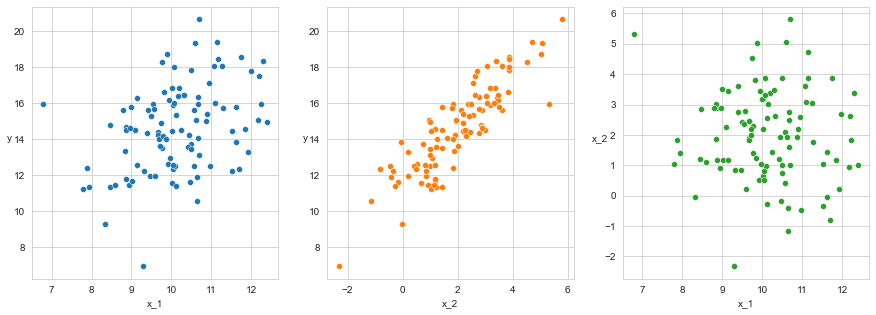

In [3]:
def scatter_plot(X, y):
    _ , ax = plt.subplots(1,3,figsize=(15,5))
    sns.scatterplot( x=X[:,0], y=y , ax=ax[0], color = sns.color_palette()[0])
    ax[0].set_xlabel('x_1');
    ax[0].set_ylabel('y',rotation=0);
    sns.scatterplot( x=X[:,1], y=y,  ax=ax[1], color = sns.color_palette()[1])
    ax[1].set_xlabel('x_2');
    ax[1].set_ylabel('y',rotation=0);
    sns.scatterplot( x=X[:,0], y=X[:,1],  ax=ax[2], color = sns.color_palette()[2])
    ax[2].set_xlabel('x_1');
    ax[2].set_ylabel('x_2',rotation=0);

scatter_plot(X, y)

Теперь используем библиотеку PyMC3 для определения модели, соответствующей множественной линейной регрессии. Хотя код выглядит почти так же, как при создании модели простой линейной регрессии. Тем не менее имеются существенные различия:
* переменная $\beta$ представляет собой гауссово распределение с коэффициентом формы shape=2, то есть определяется по одному углу наклона для каждой независимой переменной;
* переменная $\mu$ определяется с применением функции скалярного произведения pm.math.dot().

В принципе в NumPy, включена функция скалярного произведения, но здесь мы воспользуемся функцией скалярного произведения из библиотеки PyMC3, которая является всего лишь нотацией оператора умножения матриц из библиотеки Theano. Этот вариант выбран потому, что переменная $\beta$ является тензором, определенным в библиотеке Theano, а не массивом NumPy.

In [4]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ε = pm.HalfCauchy('ε', 5)
    μ = α_tmp + pm.math.dot(X_centered, β)
    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β)) 
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β, α_tmp]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 9 seconds.


In [5]:
varnames = ['α', 'β', 'ε'] 
az.summary(trace_mlr, var_names=varnames)

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α[0],1.853,0.452,1.006,2.694,0.005,0.003,9864.0,9018.0,9888.0,4741.0,1.0
β[0],0.969,0.044,0.887,1.050,0.000,0.000,9771.0,9771.0,9777.0,4591.0,1.0
β[1],1.470,0.032,1.410,1.531,0.000,0.000,10012.0,10012.0,10008.0,4802.0,1.0
ε,0.473,0.035,0.408,0.537,0.000,0.000,8942.0,8942.0,8699.0,3883.0,1.0


Здесь можно видеть, что используемая модель способна восстанавливать правильные значения (проверяем значения, которые были использованы для генерации синтезируемых данных).

Нижемы поговорим о некоторых мерах предосторожности, которые следует предпринять при анализе результатов модели множественной линейной регрессии, особенно при интерпретации углов наклона. 

Особенно важно помнить о том, что при использовании множественной линейной регрессии каждый отдельный параметр имеет смысл только в контексте всех остальных параметров.

## Экзогенные, эндогенные и контрольные переменные 

Пусть у нас имеется $y=f(x,z)$. При этом переменная $z$, коррелирует с  переменной $x$ и одновременно с прогнозируемой переменной $y$. Будем называть $x$ и $z$ связанными переменными. Предположим, что эта переменная $z$ является ответственной за причинно-следственные связи $x$ и $y$. Переменная $x$ является экзогенной, $z$ и $y$ - эндогенные.

Например, $z$ может быть промышленной революцией, $x$ – количеством солнечных дней, а $y$ – концентрацией $CO_2$ в атмосфере.  

Если исключить $z$ из анализа, то можно получить превосходную линейную связь между $x$ и $y$. Возможно, удастся даже прогнозировать $y$ по $x$. 

Но если настоящий интерес вызывает понимание причин глобального потепления, то смысл того, что происходит в действительности, может быть полностью утерян при использовании применяемого в данном примере механизма, связывающего эти переменные.

Вы уже должны знать, что корреляция не означает причинно-следственной связи и понимать, что во многих  реальных ситуациях $z$ легко упустить.

Возможно, эта переменная не измеряется или отсутствует в предоставленном нам наборе данных, или мы даже не задумывались над тем, что такая переменная может быть связана с решаемой задачей. Игнорирование экзогенных переменных при анализе может привести к установлению ложных корреляций.

Это вечная проблема при попытках объяснения чего-либо, а кроме того, может становиться проблемой при попытках прогнозирования без уделения достаточного внимания пониманию внутреннего механизма явления. Понимание внутреннего механизма помогает перенести и применить полученные ранее знания в новые ситуации. 

Например, количество красовок, производимых в одной стране, можно использовать как легко измеряемый показатель мощности ее экономики, но, возможно, прогноз на основе этого показателя окажется совершенно неприемлемым для других стран с отличающейся структурой производства.

Воспользуемся искусственно сгенерированными данными для более глубокого понимания концепции экзогенных переменных. В приведенном ниже фрагменте кода имитируется экзогенная переменная $x_1$. Отметим, что эта переменная оказывает воздействие на переменные $x_2$ и $y$.


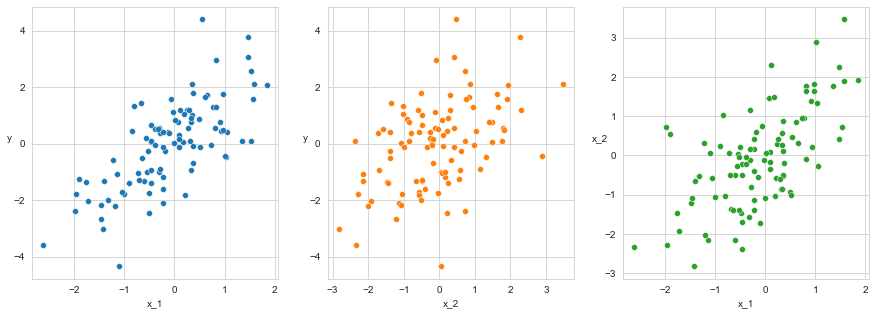

In [6]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1) 
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

Теперь создадим три связанные модели: 
* первая m_x1x2 – модель линейной регрессии с двумя независимыми переменными $x_1$ и $x_2$ (объединенными в переменной $X$)
* вторая модель m_x1 представляет собой простую линейную регрессию для переменной $x_1$
* третья модель m_x2 – простая линейная регрессия для $x_2$

In [7]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10) 
    β1 = pm.Normal('β1', mu=0, sd=10) 
    β2 = pm.Normal('β2', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x1x2 = pm.sample(2000)

with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10) 
    β1 = pm.Normal('β1', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10) 
    β2 = pm.Normal('β2', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β2, β1, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β1, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β2, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


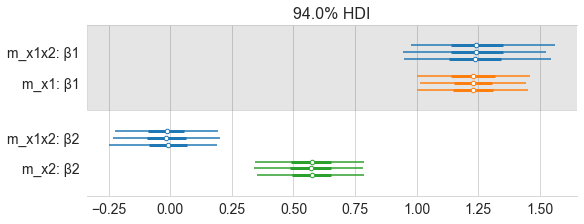

In [8]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], 
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, 
               colors='cycle', 
               figsize=(8, 3));

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


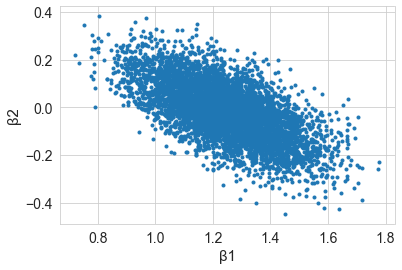

In [9]:
az.plot_pair(trace_x1x2, var_names=['β1', 'β2']);

Здесь можно видеть, что значение параметра $\beta_2$ в модели m_x1x2 близко к нулю, что свидетельствует о почти нулевом вкладе переменной $x_2$ в объяснение $y$. 

Этот факт заслуживает внимания, поскольку уже известно (по результатам проверки искусственно сгенерированных данных), что действительно важной переменной является $x_1$. 

Также отметим, что значение параметра $\beta_2$ в модели m_x2 близко к 0.55 – и это очень важно. 

Это значение больше, чем для модели m_x1x2. Сила воздействия $x_2$ на прогнозирование y снижается, когда мы принимаем во внимание переменную $x_1$, то есть информация в $x_2$ является избыточной при наличии $x_1$.

### Мультиколлинеарность или слишком сильная корреляция

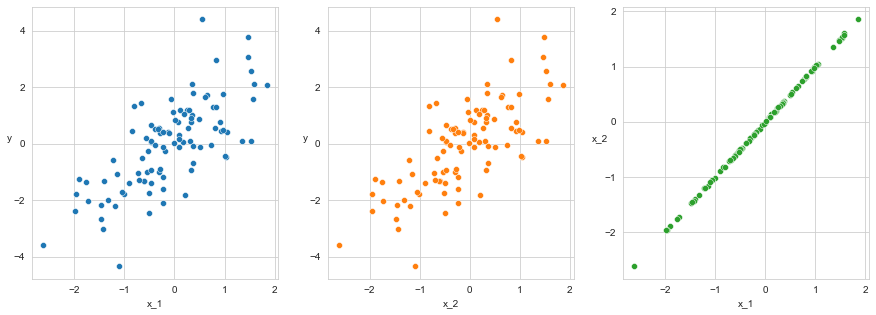

In [10]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01) 
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T
scatter_plot(X, y)

In [11]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + pm.math.dot(X, β)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_red = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 37 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 311 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.663830703302014, but should be close to 0.8. Try to increase the number of tuning steps.
There were 69 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


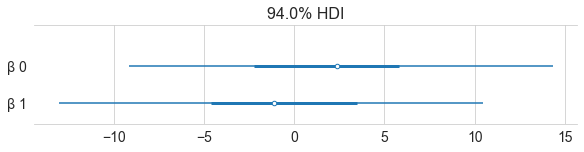

In [12]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2));

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


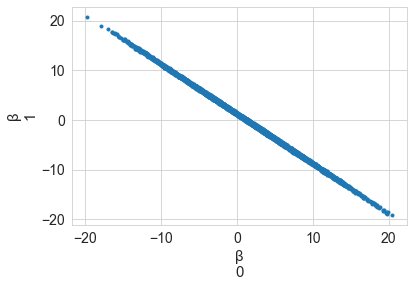

In [13]:
az.plot_pair(trace_red, var_names=['β']);

Неожиданностью является то, что граничное апостериорное распределение для $\beta$ представляет собой весьма тонкую диагональную линию. При возрастании значения одного коэффициента $\beta$ другой должен убывать. Между этими двумя коэффициентами существует сильная корреляция. Это явное следствие применения конкретной выбранной модели и конкретных данных. В соответствии с примененной в рассматриваемом примере моделью среднее значение $\mu$ равно:
$$\mu = \alpha + \beta_1 x_1 +\beta_2 x_2 $$

Если предположить, что $x_1$ и $x_2$ не совсем равны с практической точки зрения, но математически идентичны, то можно переписать модель следующим образом:
$$\mu = \alpha + (\beta_1 + \beta_2) x $$

При этом оказывается, что на среднее значение $\mu$ воздействует сумма коэффициентов $\beta_1$ и $\beta_2$, а не их отдельные значения. 
Можно постепенно уменьшать значение $\beta_1$, пока не будет получено значение $\beta_2$. Таким образом, у нас практически нет двух переменных $x$, следовательно, практически нет двух параметров $\beta$. <br>
Такую модель можно назвать недетерминированной (или, что то же самое, данные невозможно ограничить параметрами в этой модели). <br>
В рассматриваемом примере существует две причины, по которым значение $\beta$ не может свободно изменяться в интервале $[–\infty, +\infty]$. 
* во-первых, обе переменные почти одинаковы, но не равны в точности; 
* во-вторых, что наиболее важно, здесь применяется априорное распределение, ограничивающее возможные значения, которые может принимать $\beta$.

В рассмотренном выше примере заслуживает внимания,что прежде всего апостериорное распределение является не чем иным, как логическим следствием, выведенным из исследуемых данных и применяемой модели, поэтому нет ничего противоестественного в получении столь широкого размаха распределений для $\beta$, «такова жизнь». 

В любом реальном наборе данных корреляции всегда будут существовать в той или иной степени. Насколько сильной должна быть корреляция между двумя или несколькими переменными, чтобы стать проблемой? 

К сожалению, статистика – это раздел математики, в котором почти нет магических чисел, их всего лишь несколько. Всегда есть возможность сформировать корреляционную матрицу перед запуском любой байесовской модели и проверить переменные с сильной корреляцией, например большей 0.9 и т. д. <br>
Но в любом случае при таком подходе действительная проблема заключается не в корреляции, наблюдаемой между парами элементов корреляционной матрицы, а в корреляции переменных внутри модели. <br>
Как уже было отмечено выше, поведение переменных в изолированном контексте отличается от их поведения, когда они объединены в модели. Две и более переменных могут увеличивать или уменьшать корреляцию между собой, когда они размещаются в контексте других переменных в модели множественной линейной регрессии. <br>
Как всегда, настоятельно рекомендуется внимательное исследование апостериорного распределения в совокупности с итеративным критическим подходом к созданию модели. Это может помочь выявить проблемы и лучше понять данные и модели.

В качестве краткого руководства ниже приведены рекомендации для тех случаев, когда обнаружены переменные с сильной корреляцией:

* если корреляция действительно сильная, то можно исключить одну переменную из анализа, особенно если допускается, что обе переменные содержат одинаковую или почти одинаковую информацию. В последнем случае не имеет значения, какая переменная исключается. Можно исключать переменные только из соображений удобства, например удалить переменную с наименее известным (значимым) смыслом в данной области знаний или переменную, которую труднее всего интерпретировать или измерять;
* можно создать новую переменную, усредняющую избыточные переменные. Более усовершенствованной версией этого подхода является использование алгоритма сокращения переменных, например метод главных компонентов (PCA). Проблема применения метода главных компонентов состоит в том, что получаемые в результате переменные являются линейными комбинациями исходных переменных, что в общем случае создает серьезные затруднения при интерпретации результатов;
* еще один вариант решения – применить более строгие априорные распределения для ограничения возможных значений, которые может принимать коэффициент. Мы поговорим об этом в лекции о сравнение моделей». Там краткообсудим некоторые варианты выбора таких априорных распределений, называемых регуляризирующими априорными распределениями.

## Маскировочный эффект 

Создадим небольшой искусственный набор данных для демонстрации этого явления. По существу, создаются две независимые переменные $x_1$ и $x_2$. Между ними существует положительная корреляция, а кроме того, имеется корреляция с переменной $y$, но в противоположных направлениях: корреляция между $x_1$ и y положительная, а корреляция между $x_2$ и $y$ отрицательная.

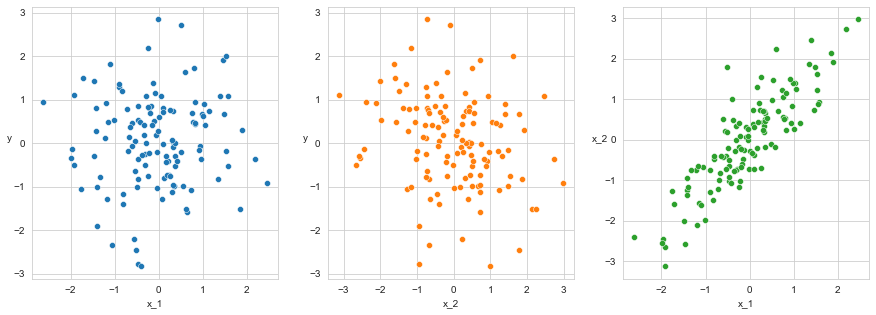

In [14]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2) 
X = np.vstack((x_1, x_2)).T 

scatter_plot(X, y)

In [15]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10) 
    β1 = pm.Normal('β1', mu=0, sd=10) 
    β2 = pm.Normal('β2', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0] + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x1x2 = pm.sample(2000)

with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10) 
    β1 = pm.Normal('β1', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β1 * X[:, 0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x1 = pm.sample(2000)
    
with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10) 
    β2 = pm.Normal('β2', mu=0, sd=10) 
    ε = pm.HalfCauchy('ε', 5)
    μ = α + β2 * X[:, 1]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=y) 
    trace_x2 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β2, β1, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β1, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [ε, β2, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 8 seconds.


/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


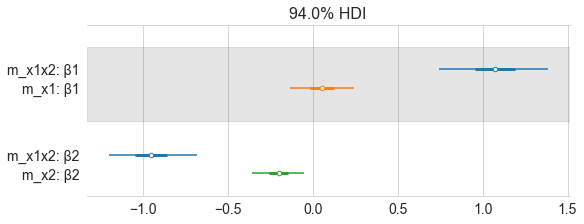

In [16]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2], 
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, 
               figsize=(8, 3));

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


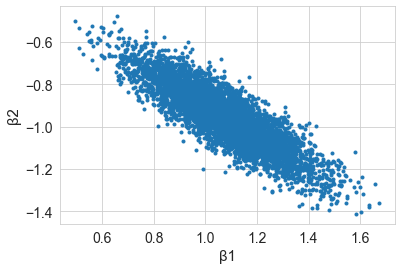

In [17]:
az.plot_pair(trace_x1x2, var_names=['β1', 'β2']);

В соответствии с апостериорным распределением значения $\beta$ для модели m_x1x2 близки к 1 и –1 (как и ожидалось в соответствии со способом генерации данных). 
Для модели простой линейной регрессии, то есть когда каждая переменная исследуется независимо от других, можно видеть, что значения $\beta$ в этом случае ближе к нулю, свидетельствуя о более слабом эффекте.

Отметим, что $x_1$ коррелирует с $x_2$. Фактически это означает, что при увеличении $x_1$ также увеличивается $x_2$. Кроме того, отметим, что при увеличении $y$ переменная $x_1$ тоже увеличивается, но переменная $x_2$ уменьшается. 

В результате применения этой конкретной схемы регулирования мы получаем частичную отмену эффектов, если только не включаем обе переменные в одну и ту же линейную регрессию. Модель линейной регрессии способна распространять эти эффекты, так как она обучается на каждой точке данных, то есть узнает, какой вклад вносит $x_1$ в значение $y$ при определенном значении $x_2$, а также величину вклада $x_2$ при определенном значении $x_1$.

 ### Добавление взаимодействий
 
До настоящего момента в определении модели линейной регрессии объявлялось (неявно), что любые изменения переменной $x_i$ приводят к изменениям на постоянную величину значения переменной $y$ при сохранении неизменными значений всех прочих прогнозирующих переменных. Но, разумеется, это положение не всегда истинно. Возможна ситуация, когда изменения переменной $x_i$ воздействуют на $y$ в зависимости от изменения переменной $x_j$. 

Классическим примером такого поведения является совместное действие различных лекарственных препаратов. Например, увеличение дозы препарата $A$ оказывает на пациента положительное воздействие. Это истинно при отсут- ствии препарата $B$ (или при малой дозе препарата $B$), но эффект от применения $A$ становится отрицательным (или даже может привести к смертельному исходу) при увеличении дозы $B$.

Во всех рассмотренных выше примерах зависимые переменные демонстрировали накопительный (суммируемый) вклад в значение прогнозируемой переменной. Мы просто добавляли переменные (с умножением на некоторый коэффициент). Если требуется сбор данных об эффектах, как в примере с лекарственными препаратами, то необходимо включить в модель члены, которые не являются аддитивными. Часто применяется вариант умножения переменных, например:
$$ \mu = \alpha + (\beta_1 + \beta_3 x_2) x_1 + \beta_2 x_2 $$ 
$$ \mu = \alpha +  \beta_1 x_1 + (\beta_2 + \beta_3 x_1) x_2 $$ 

Таким образом:
* член взаимодействия можно понимать как линейную модель, а следовательно выражение для среднего значения $\mu$ представляет собой линейную модель, в состав которой включена еще одна линейная модель;
* взаимодействие симметрично – его можно интерпретировать как коэффициент угла наклона $x_1$ в форме функции от $x_2$ и в то же время как коэффициент угла наклона $x_2$ в форме функции от $x_1$;
* в модели множественной линейной регрессии без взаимодействий мы получаем гиперплоскость, то есть плоскую гиперповерхность. Член взаимодействия создает кривизну на этой гиперповерхности. Причина этого явления в том, что углы наклона перестают быть константами, а становятся функциями другой переменной;
* коэффициент $\beta_1$ описывает влияние прогнозирующей переменной $x_1$ только при $x_2 = 0$. Этот факт является истинным, потому что при этом $\beta_3 x_2 = 0$, следовательно, коэффициент угла наклона $x_1$ сокращается до $\beta_1 x_1$. По правилу симметричности взаимодействия то же самое обоснование можно применить и к коэффициенту $\beta_2$.

## Дисперсия переменной

Пока мы воспользовались линейной последовательностью для моделирования среднего значения распределения, а в предыдущем разделе использовали ее для моделирования взаимодействий. 

Линейную последовательность можно также применять для моделирования стандартного отклонения, когда предварительные предположения о постоянной дисперсии не имеют смысла. В этих случаях может потребоваться представление СКО в виде (линейной) функции от зависимой переменной.

Всемирная организация здравоохранения (ВОЗ) и другие организации, занимающиеся охраной здоровья, собирают данные по всему миру о новорожденных и о детях.

Примером таких данных является рост (длина тела) новорожденных девочек как функция от возраста (в месяцах):

,Month,Lenght
0,0,48.5
1,0,50.5
2,0,50.5


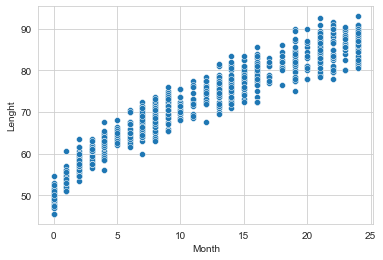

In [18]:
data = pd.read_csv('babies.csv') 
display(data.head(3))
sns.scatterplot(x = 'Month', y= 'Lenght', data=data);

Для моделирования этих данных введем три новых элемента, которых не было в ранее рассмотренных моделях:
* $\varepsilon$ – теперь это линейная функция от $x$. Для этого добавляются два новых параметра $\gamma$ и $\delta$ – прямые аналоги $\alpha$ и $\beta$;
* линейная модель для среднего значения – это функция от $x$. Это всего лишь обычный простой прием для подгонки линейной модели к некоторой кривой;
* определяется совместно используемая (разделяемая) переменная <code>x_shared</code>. Она будет использоваться для изменения значений переменной x (в рассматриваемом примере – Month) после подгонки модели без необходимости ее повторной подгонки. 

Итак:


In [19]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10) 
    δ = pm.HalfNormal('δ', sd=10)
    x_shared = pm.Data('x_shared',data.Month.values.astype('float32'))
    μ = pm.Deterministic('μ', α + β * x_shared**0.5) 
    ε = pm.Deterministic('ε', γ + δ * x_shared)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ε, observed=data.Lenght)
    trace_vv = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [δ, γ, β, α]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 10 seconds.


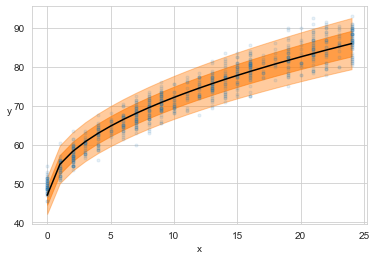

In [20]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = trace_vv['μ'].mean(0)
ε_m = trace_vv['ε'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, 
                 μ_m + 1 * ε_m, μ_m - 1 * ε_m, 
                 alpha=0.6, color='C1')
plt.fill_between(data.Month, 
                 μ_m + 2 * ε_m, μ_m - 2 * ε_m, 
                 alpha=0.4, color='C1')

plt.xlabel('x');
plt.ylabel('y', rotation=0);

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


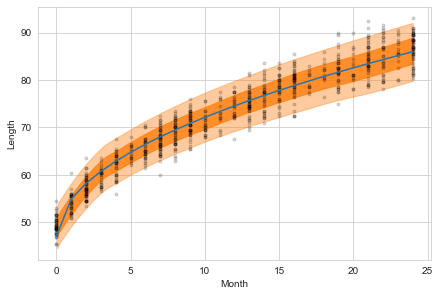

In [21]:
with model_vv:
    pp_length = pm.sample_posterior_predictive(trace_vv)['y_pred']


ax0 = az.plot_hdi(data.Month, pp_length, fill_kwargs={"alpha": 0.4})  
az.plot_hdi(data.Month, pp_length, hdi_prob=0.6, fill_kwargs={"alpha": 0.8}, ax = ax0)
    
plt.plot(data.Month, data.Lenght, "k.", alpha=0.15)
plt.plot(data.Month, trace_vv["μ"].mean(0))


plt.xlabel("Month")
plt.ylabel("Length");

Таким образом можно вычислить, например распределении  роста для детей в возрасте 0.5 месяца:

/Users/imachome/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


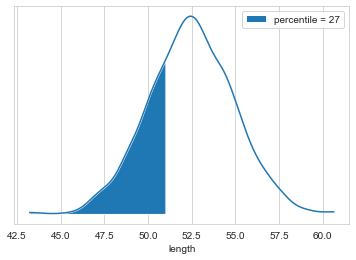

In [25]:
with model_vv:
    pm.set_data({'x_shared': [0.5]})
    y_ppc = pm.sample_posterior_predictive(trace_vv, 2000)

y_ppc = y_ppc['y_pred'][:,0]

ref = 51
x, y = az.kde(y_ppc)
x_ = np.linspace(np.min(x), np.max(x), x.size)
plt.plot(x,y)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], y[x_ < ref], 
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend();